In [1]:
from LRL import *
from tqdm import tqdm

In [2]:
USE_CUDA

True

# Pong

In [3]:
def create_env():
    def _thunk():
        env = gym.make("PongNoFrameskip-v4")
        env = atari_wrappers.NoopResetEnv(env, noop_max=30)  # do nothing first from 1 to 30 frames 
        env = atari_wrappers.MaxAndSkipEnv(env, skip=4)      # return each 4-th frame with max over these 4 frames
        env = atari_wrappers.EpisodicLifeEnv(env)            # return done when loosing life
        env = atari_wrappers.FireResetEnv(env)               # pressing fire starts the game
        env = atari_wrappers.WarpFrame(env)                  # turn frame to grayscale 84x84
        env = atari_wrappers.ClipRewardEnv(env)              # get sign(reward) instead of reward
        env = atari_wrappers.ImageToPyTorch(env)             # pytorch wants channels x W x H
        return env
    return _thunk

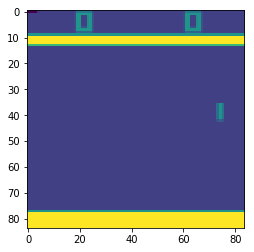

In [4]:
plt.imshow(create_env()().reset()[0].T)

In [5]:
class PongCnn(nn.Module):
    def __init__(self, linear):
        super(PongCnn, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        
        self.fc = nn.Sequential(
            linear(self.feature_size(), 512),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def feature_size(self):
        return self.features(torch.zeros(1, 1, 84, 84)).view(1, -1).size(1)

In [6]:
logs = {}

### Help functions

In [7]:
from scipy.signal import medfilt, lfilter

def sliding_mean(a, window_size):
    """one-liner for sliding average for array a with window size window_size"""
    return np.convolve(np.concatenate([np.ones((window_size - 1)) * a[0], a]), np.ones((window_size))/window_size, mode='valid')

def sliding_std(a, window_size):
    average = sliding_average(a, window_size)
    return sliding_average((a - average)**2, window_size)**0.5

def discounted_R(rewards, discount):
    return lfilter([1], [1, -discount], x=rewards[::-1])[::-1]

# DQN

In [8]:
config = {
    "make_env": create_env,
    "Qnetwork_FeatureExtractor": PongCnn,
    "QnetworkHead": Qnetwork,
    "Qnetwork_optimizer_args": {"lr": 0.0001},
    "target_update": 1000,
    "batch_size": 32,
    "replay_buffer_init": 10000,
    "gamma": 0.99,
    "replay_buffer_capacity": 1000000,
    "epsilon_start": 1.0, "epsilon_final": 0.01, "epsilon_decay": 30000
}

In [9]:
agent = eGreedy(TargetQAgent(QAgent(ReplayBufferAgent)))(config)

In [10]:
agent.load("Models/pong_dqn_8thr2steps128bs")

In [11]:
# number of parameters
agent.q_net.numel()

1681062

In [12]:
# average fps
1 / np.mean(1 / np.array(agent.logger['fps']))

168.4305031285651

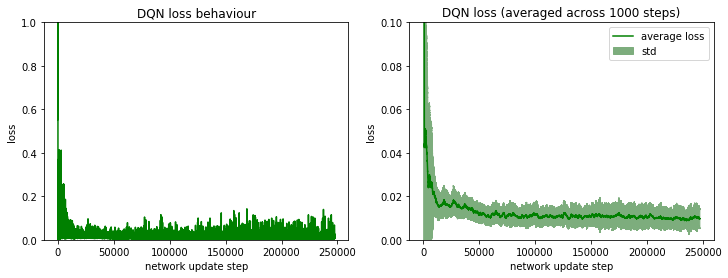

In [13]:
f = plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(agent.logger["Qnetwork_loss"], color="green")
plt.xlabel("network update step")
plt.ylim(0, 1)
plt.ylabel("loss")
plt.title("DQN loss behaviour")

plt.subplot(122)
average = sliding_mean(agent.logger["Qnetwork_loss"], 1000)
std = sliding_std(agent.logger["Qnetwork_loss"], 1000)

plt.plot(average, color="green", label="average loss")
fb = plt.fill_between(np.arange(len(average)), average - std, average + std, color="#7DAD7D", label="std")
fb.set_rasterized(True)

plt.ylim(0, 0.1)
plt.xlabel("network update step")
plt.ylabel("loss")
plt.title("DQN loss (averaged across 1000 steps)")
plt.legend()

f.savefig("DQNloss.pdf", bbox_inches='tight')

In [14]:
agent.play(record=True, show_record=False)

20.0

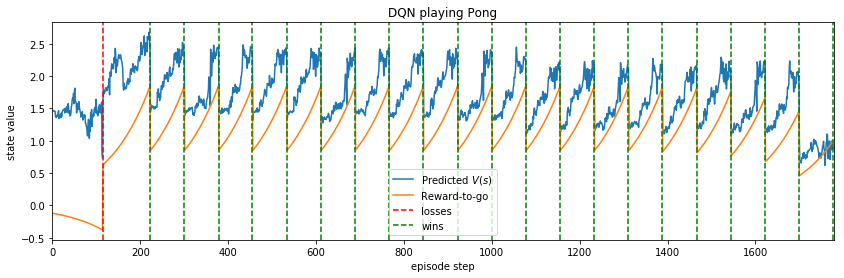

In [15]:
f = plt.figure(figsize=(14, 4))

Q = np.array(agent.record['qualities'])[:, 0]
plt.plot(Q.max(1), label="Predicted $V(s)$")

R = np.array(agent.record['reward'])[:, 0]
plt.plot(discounted_R(R, agent.config.gamma), label="Reward-to-go")

lost, won = (R < 0).nonzero()[0], (R > 0).nonzero()[0]

plt.axvline(lost[0], color="red", linestyle="--", label="losses")
for t in lost[1:]:
        plt.axvline(t, color="red", linestyle="--")
        
plt.axvline(won[0], color="green", linestyle="--", label="wins")      
for t in won[1:]:
    plt.axvline(t, color="green", linestyle="--")
    
plt.xlim(0, len(Q))
plt.xlabel("episode step")
plt.ylabel("state value")
plt.legend()
plt.title("DQN playing Pong")

f.savefig("DQNplay.pdf", bbox_inches='tight')

In [13]:
logs["DQN"] = agent.logger

In [14]:
agent.load("Models/pong_dqn")

In [15]:
# average fps
1 / np.mean(1 / np.array(agent.logger['fps']))

55.73806462110732

In [16]:
logs["DQN vanilla"] = agent.logger

# Categorical DQN
(no target network)

In [17]:
config = {
    "make_env": create_env,
    "Qnetwork_FeatureExtractor": PongCnn,
    "QnetworkHead": CategoricalQnetwork,
    "Qnetwork_optimizer_args": {"lr": 0.0001},
    "batch_size": 32,
    "replay_buffer_init": 10000,
    "gamma": 0.99,
    "replay_buffer_capacity": 1000000,
    "epsilon_start": 1.0, "epsilon_final": 0.01, "epsilon_decay": 30000,    
    "Vmin": -10, "Vmax": 10, "num_atoms": 51
}

In [18]:
agent = eGreedy(CategoricalQAgent(ReplayBufferAgent))(config)

In [19]:
agent.load("Models/pong_c51_8thr2steps128bs")

In [23]:
# number of parameters
agent.q_net.numel()

1834962

In [24]:
# average fps
1 / np.mean(1 / np.array(agent.logger['fps']))

148.7632242920926

In [25]:
c51_loss = agent.logger["Qnetwork_loss"]

In [26]:
agent.play(record=True, show_record=False)

20.0

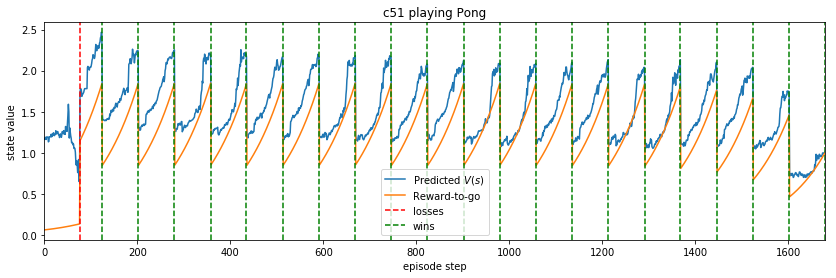

In [27]:
f = plt.figure(figsize=(14, 4))

Q = (np.array(agent.record['qualities'])[:, 0] * agent.support.cpu().numpy()).sum(axis=2)
plt.plot(Q.max(1), label="Predicted $V(s)$")

R = np.array(agent.record['reward'])[:, 0]
plt.plot(discounted_R(R, agent.config.gamma), label="Reward-to-go")

lost, won = (R < 0).nonzero()[0], (R > 0).nonzero()[0]

plt.axvline(lost[0], color="red", linestyle="--", label="losses")
for t in lost[1:]:
        plt.axvline(t, color="red", linestyle="--")
        
plt.axvline(won[0], color="green", linestyle="--", label="wins")      
for t in won[1:]:
    plt.axvline(t, color="green", linestyle="--")
    
plt.xlim(0, len(Q))
plt.xlabel("episode step")
plt.ylabel("state value")
plt.legend()
plt.title("c51 playing Pong")

f.savefig("c51play.pdf", bbox_inches='tight')

In [28]:
a = np.argmax((np.array(agent.record['qualities'])[:, 0] * agent.support.cpu().numpy()).sum(axis=2), axis=1)
Z = np.array(agent.record['qualities'])[:, 0]
Z = Z[np.arange(len(Z)), a]

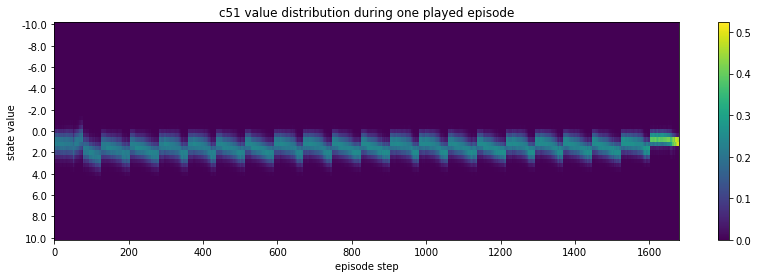

In [29]:
f = plt.figure(figsize=(14, 4))
plt.imshow(Z.T, aspect="auto")
plt.yticks(np.arange(51)[::5], agent.support.cpu().numpy()[::5])
plt.colorbar()

plt.xlabel("episode step")
plt.ylabel("state value")
plt.title("c51 value distribution during one played episode")

f.savefig("c51playvd.pdf", bbox_inches='tight')

In [20]:
logs["c51"] = agent.logger

In [21]:
agent.load("Models/pong_c51")

In [22]:
# average fps
1 / np.mean(1 / np.array(agent.logger['fps']))

44.07967979228042

In [23]:
logs["c51 vanilla"] = agent.logger

In [24]:
agent.load("Models/pong_c51_take2")

In [25]:
# average fps
1 / np.mean(1 / np.array(agent.logger['fps']))

47.739075715652575

In [26]:
logs["c51 vanilla 2"] = agent.logger

# Quantile Regression DQN

In [27]:
config = {
    "make_env": create_env,
    "Qnetwork_FeatureExtractor": PongCnn,
    "QnetworkHead": QuantileQnetwork,
    "Qnetwork_optimizer_args": {"lr": 0.0001},
    "target_update": 1000,
    "batch_size": 32,
    "replay_buffer_init": 10000,
    "gamma": 0.99,
    "replay_buffer_capacity": 1000000,
    "epsilon_start": 1.0, "epsilon_final": 0.01, "epsilon_decay": 30000,
    "quantiles": 51
}

In [28]:
agent = eGreedy(TargetQAgent(QuantileQAgent(ReplayBufferAgent)))(config)

In [29]:
agent.load("Models/pong_qrdqn_8thr2steps128bs")

In [37]:
# number of parameters
agent.q_net.numel()

1834962

In [38]:
# average fps
1 / np.mean(1 / np.array(agent.logger['fps']))

155.97415599450756

In [39]:
qr_loss = agent.logger["Qnetwork_loss"]

In [40]:
agent.play(record=True, show_record=False)

8.0

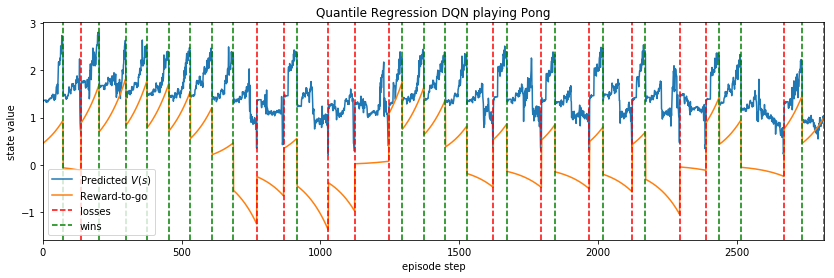

In [41]:
f = plt.figure(figsize=(14, 4))

Q = (np.array(agent.record['qualities'])[:, 0]).mean(axis=2)
plt.plot(Q.max(1), label="Predicted $V(s)$")

R = np.array(agent.record['reward'])[:, 0]
plt.plot(discounted_R(R, agent.config.gamma), label="Reward-to-go")

lost, won = (R < 0).nonzero()[0], (R > 0).nonzero()[0]

plt.axvline(lost[0], color="red", linestyle="--", label="losses")
for t in lost[1:]:
        plt.axvline(t, color="red", linestyle="--")
        
plt.axvline(won[0], color="green", linestyle="--", label="wins")      
for t in won[1:]:
    plt.axvline(t, color="green", linestyle="--")
    
plt.xlim(0, len(Q))
plt.xlabel("episode step")
plt.ylabel("state value")
plt.legend()
plt.title("Quantile Regression DQN playing Pong")

f.savefig("QRplay.pdf", bbox_inches='tight')

In [42]:
a = np.argmax((np.array(agent.record['qualities'])[:, 0]).sum(axis=2), axis=1)
Z = np.array(agent.record['qualities'])[:, 0]
Z = Z[np.arange(len(Z)), a]

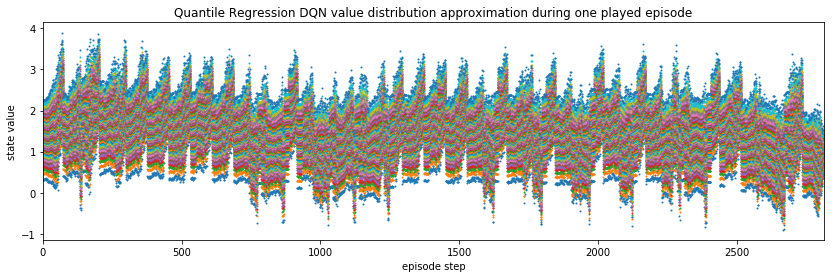

In [43]:
f = plt.figure(figsize=(14, 4))
for i in range(51):
    plt.scatter(np.arange(len(Z)), Z[:, i], s=1)

plt.xlim(0, len(Z))
plt.xlabel("episode step")
plt.ylabel("state value")
plt.title("Quantile Regression DQN value distribution approximation during one played episode")

f.savefig("QRplayvd.pdf", bbox_inches='tight')

In [30]:
logs["QR-DQN"] = agent.logger

In [31]:
agent.load("Models/pong_qrdqn")

In [32]:
# average fps
1 / np.mean(1 / np.array(agent.logger['fps']))

47.458469719804654

In [33]:
logs["QR-DQN vanilla"] = agent.logger

In [34]:
agent.load("Models/pong_qrdqn_take2")

In [35]:
# average fps
1 / np.mean(1 / np.array(agent.logger['fps']))

49.54075670614405

In [36]:
logs["QR-DQN vanilla 2"] = agent.logger

# Rainbow

In [37]:
config = {
    "make_env": create_env,
    "Qnetwork_FeatureExtractor": PongCnn,
    "QnetworkHead": DuelingCategoricalQnetwork,
    "Qnetwork_optimizer_args": {"lr": 0.0001}, # {"lr": 0.0000625, "eps": 0.00015},
    "Qnetwork_linear": NoisyLinear(std_init=0.5),
    "target_update": 1000,
    "batch_size": 32,
    "replay_buffer_nsteps": 3,
    "replay_buffer_init": 10000,
    "gamma": 0.99,
    "replay_buffer_capacity": 1000000,
    "rp_alpha": 0.5, "rp_beta_start": 0.4, "rp_beta_frames": 100000,
    "Vmin": -10, "Vmax": 10, "num_atoms": 51
}

In [38]:
agent = DoubleQAgent(CategoricalQAgent(NstepReplay(PrioritizedBufferAgent)))(config)

In [39]:
agent.load("Models/pong_rainbow_8thr2steps128bs")

In [40]:
# number of parameters
agent.q_net.numel()

3650410

In [41]:
# average fps
1 / np.mean(1 / np.array(agent.logger['fps']))

70.22457023209466

In [53]:
rainbow_loss = agent.logger["Qnetwork_loss"]

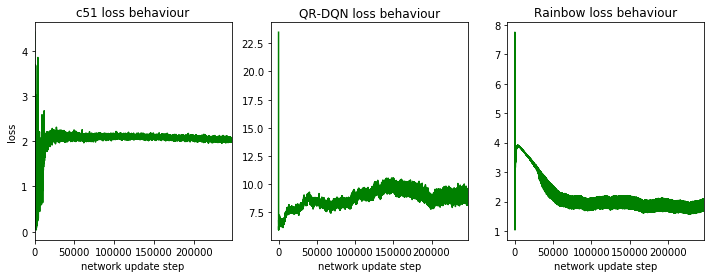

In [56]:
f = plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.plot(c51_loss, color="green")
plt.xlabel("network update step")
plt.xlim(0, len(c51_loss))
plt.ylabel("loss")
plt.title("c51 loss behaviour")

plt.subplot(132)
plt.plot(qr_loss, color="green")
plt.xlabel("network update step")
plt.xlim(-10000, len(qr_loss))
plt.title("QR-DQN loss behaviour")

plt.subplot(133)
plt.plot(rainbow_loss, color="green")
plt.xlabel("network update step")
plt.xlim(-10000, len(rainbow_loss))
plt.title("Rainbow loss behaviour")

f.savefig("ThreeLosses.pdf", bbox_inches='tight')

In [42]:
agent.logger.keys()

dict_keys(['fps', 'rewards', 'episode ends', 'median weight', 'Qnetwork_loss', 'Qnetwork_magnitude'])

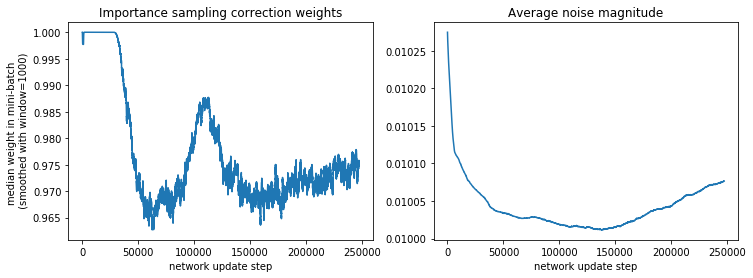

In [49]:
f = plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(sliding_mean(agent.logger['median weight'], 1000))
plt.xlabel("network update step")
#plt.xlim(0, len(c51_loss))
plt.ylabel("median weight in mini-batch \n (smoothed with window=1000)")
plt.title("Importance sampling correction weights")

plt.subplot(122)
plt.plot(np.arange(len(agent.logger['Qnetwork_magnitude']))*20, agent.logger['Qnetwork_magnitude'])
plt.xlabel("network update step")
#plt.xlim(-10000, len(qr_loss))
plt.title("Average noise magnitude")

f.savefig("Rainbowstats.pdf", bbox_inches='tight')

In [57]:
agent.play(record=True, show_record=False)

19.0

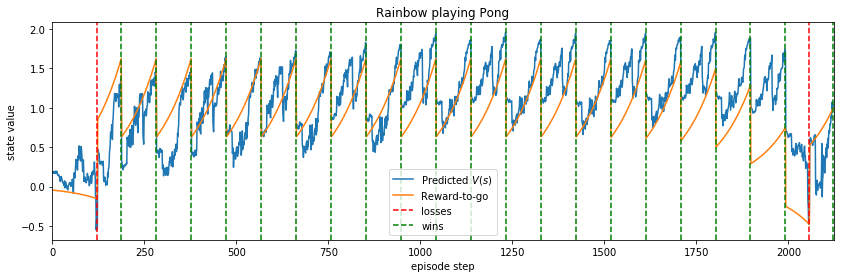

In [58]:
f = plt.figure(figsize=(14, 4))

Q = (np.array(agent.record['qualities'])[:, 0] * agent.support.cpu().numpy()).sum(axis=2)
plt.plot(Q.max(1), label="Predicted $V(s)$")

R = np.array(agent.record['reward'])[:, 0]
plt.plot(discounted_R(R, agent.config.gamma), label="Reward-to-go")

lost, won = (R < 0).nonzero()[0], (R > 0).nonzero()[0]

plt.axvline(lost[0], color="red", linestyle="--", label="losses")
for t in lost[1:]:
        plt.axvline(t, color="red", linestyle="--")
        
plt.axvline(won[0], color="green", linestyle="--", label="wins")      
for t in won[1:]:
    plt.axvline(t, color="green", linestyle="--")
    
plt.xlim(0, len(Q))
plt.xlabel("episode step")
plt.ylabel("state value")
plt.legend()
plt.title("Rainbow playing Pong")

f.savefig("Rainbowplay.pdf", bbox_inches='tight')

In [59]:
a = np.argmax((np.array(agent.record['qualities'])[:, 0] * agent.support.cpu().numpy()).sum(axis=2), axis=1)
Z = np.array(agent.record['qualities'])[:, 0]
Z = Z[np.arange(len(Z)), a]

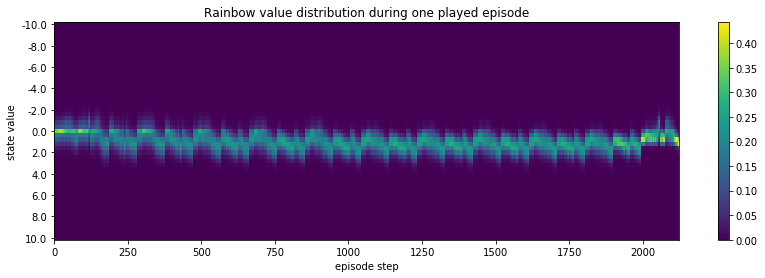

In [60]:
f = plt.figure(figsize=(14, 4))
plt.imshow(Z.T, aspect="auto")
plt.yticks(np.arange(51)[::5], agent.support.cpu().numpy()[::5])
plt.colorbar()

plt.xlabel("episode step")
plt.ylabel("state value")
plt.title("Rainbow value distribution during one played episode")

f.savefig("Rainbowplayvd.pdf", bbox_inches='tight')

In [61]:
logs["Rainbow"] = agent.logger

In [62]:
agent.load("Models/pong_rainbow")

In [63]:
# average fps
1 / np.mean(1 / np.array(agent.logger['fps']))

19.299711784120724

In [64]:
logs["Rainbow vanilla"] = agent.logger

# A2C

In [65]:
config = {
    "make_env": create_env,
    #"threads": 8,
    "ActorCritic_FeatureExtractor": PongCnn,
    "ActorCriticHead": ActorCritic,
    "ActorCritic_optimizer": optim.Adam,
    "ActorCritic_optimizer_args": {"lr": 0.0001},
    "ActorCritic_clip_gradients": 0.5,
    "rollout": 5,
    "gamma": 0.99,
    "gae_tau": 0.95,
    "critic_loss_weight": 0.5,
    "entropy_loss_weight": 0.01
}

In [66]:
agent = GAE(A2C(Agent))(config)

In [67]:
agent.load("Models/pong_A2C")

In [68]:
# number of parameters
agent.policy.numel()

1681575

In [69]:
# average fps
1 / np.mean(1 / np.array(agent.logger['fps']))

656.2499620041366

In [70]:
agent.logger.keys()

dict_keys(['ActorCritic_loss', 'actor_loss', 'critic_loss', 'entropy_loss', 'fps', 'rewards', 'episode ends'])

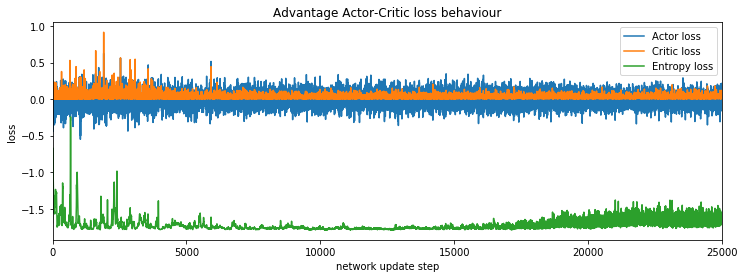

In [71]:
f = plt.figure(figsize=(12, 4))

plt.plot(agent.logger["actor_loss"], label="Actor loss")
plt.plot(agent.logger["critic_loss"], label="Critic loss")
plt.plot(agent.logger["entropy_loss"], label="Entropy loss")
#plt.plot(agent.logger["ActorCritic_loss"], label="Full loss")
plt.xlabel("network update step")
plt.xlim(0, len(agent.logger["actor_loss"]))
plt.ylabel("loss")
plt.legend()
plt.title("Advantage Actor-Critic loss behaviour")
#fb.set_rasterized(True)

f.savefig("A2Closs.pdf", bbox_inches='tight')

In [72]:
agent.play(record=True, show_record=False)

-11.0

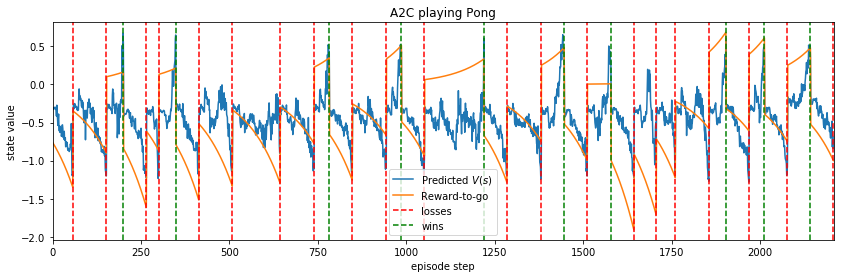

In [73]:
f = plt.figure(figsize=(14, 4))

V = np.array(agent.record['values'])[:, 0]
plt.plot(V, label="Predicted $V(s)$")

R = np.array(agent.record['reward'])[:, 0]
plt.plot(discounted_R(R, agent.config.gamma), label="Reward-to-go")

lost, won = (R < 0).nonzero()[0], (R > 0).nonzero()[0]

plt.axvline(lost[0], color="red", linestyle="--", label="losses")
for t in lost[1:]:
        plt.axvline(t, color="red", linestyle="--")
        
plt.axvline(won[0], color="green", linestyle="--", label="wins")      
for t in won[1:]:
    plt.axvline(t, color="green", linestyle="--")
    
plt.xlim(0, len(V))
plt.xlabel("episode step")
plt.ylabel("state value")
plt.legend()
plt.title("A2C playing Pong")

f.savefig("A2Cplay.pdf", bbox_inches='tight')

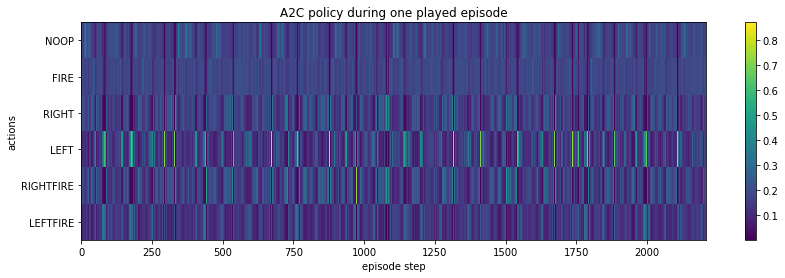

In [74]:
f = plt.figure(figsize=(14, 4))
plt.imshow(np.array(agent.record["policies"])[:, 0].T, aspect="auto")
plt.colorbar()

plt.yticks(np.arange(6), agent.env.envs[0].unwrapped.get_action_meanings())

plt.xlabel("episode step")
plt.ylabel("actions")
plt.title("A2C policy during one played episode")

f.savefig("A2Cplaypolicy.pdf", bbox_inches='tight')

In [75]:
logs["A2C"] = agent.logger

# PPO

In [76]:
config = {
    "make_env": create_env,
    #"threads": 8,
    "ActorCritic_FeatureExtractor": PongCnn,
    "ActorCriticHead": ActorCritic, #_orth_init,
    "ActorCritic_optimizer": optim.Adam,
    "ActorCritic_optimizer_args": {"lr": 0.0001}, 
    #"ActorCritic_clip_gradients": 0.5,
    "rollout": 128,
    "ppo_clip": 0.1, 
    "epochs": 3, 
    "batch_size": 32,
    "gamma": 0.99,
    "gae_tau": 0.95,
    "critic_loss_weight": 1,
    "entropy_loss_weight": 0.01,
}

In [77]:
agent = GAE(PPO(A2C(Agent)))(config)

In [78]:
agent.load("Models/pong_ppo")

In [79]:
# number of parameters
agent.policy.numel()

1681575

In [80]:
# average fps
1 / np.mean(1 / np.array(agent.logger['fps']))

327.1291321502069

In [81]:
agent.logger.keys()

dict_keys(['fps', 'ActorCritic_loss', 'actor_loss', 'critic_loss', 'entropy_loss', 'rewards', 'episode ends'])

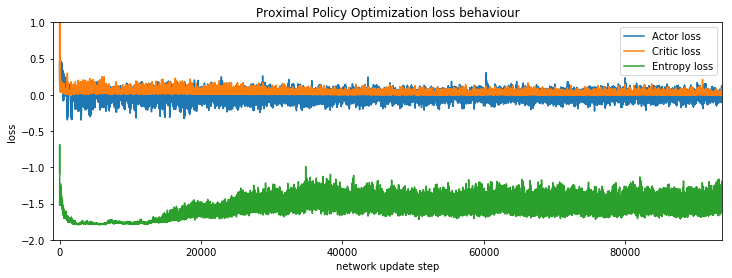

In [82]:
f = plt.figure(figsize=(12, 4))

plt.plot(agent.logger["actor_loss"], label="Actor loss")
plt.plot(agent.logger["critic_loss"], label="Critic loss")
plt.plot(agent.logger["entropy_loss"], label="Entropy loss")
#plt.plot(agent.logger["ActorCritic_loss"], label="Full loss")
plt.xlabel("network update step")
plt.xlim(-1000, len(agent.logger["actor_loss"]))
plt.ylabel("loss")
plt.ylim(-2, 1)
plt.legend()
plt.title("Proximal Policy Optimization loss behaviour")
#fb.set_rasterized(True)

f.savefig("PPOloss.pdf", bbox_inches='tight')

In [83]:
agent.play(record=True, show_record=False)

14.0

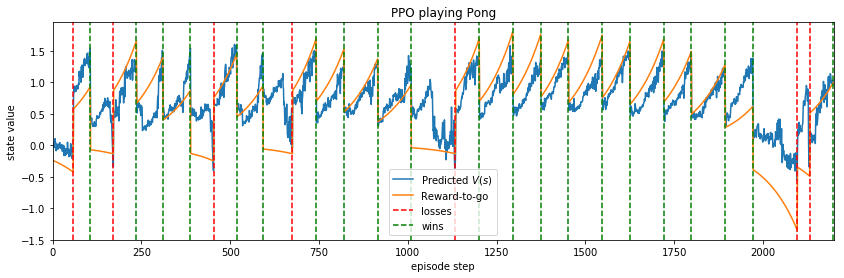

In [132]:
f = plt.figure(figsize=(14, 4))

V = np.array(agent.record['values'])[:, 0]
plt.plot(V, label="Predicted $V(s)$")

R = np.array(agent.record['reward'])[:, 0]
plt.plot(discounted_R(R, agent.config.gamma), label="Reward-to-go")

lost, won = (R < 0).nonzero()[0], (R > 0).nonzero()[0]

plt.axvline(lost[0], color="red", linestyle="--", label="losses")
for t in lost[1:]:
        plt.axvline(t, color="red", linestyle="--")
        
plt.axvline(won[0], color="green", linestyle="--", label="wins")      
for t in won[1:]:
    plt.axvline(t, color="green", linestyle="--")
    
plt.xlim(0, len(V))
plt.xlabel("episode step")
plt.ylabel("state value")
plt.legend()
plt.title("PPO playing Pong")

f.savefig("PPOplay.pdf", bbox_inches='tight')

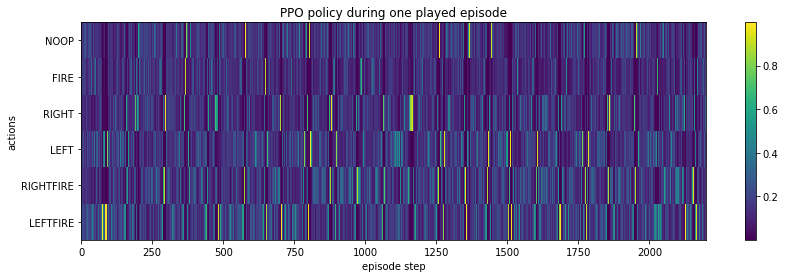

In [133]:
f = plt.figure(figsize=(14, 4))
plt.imshow(np.array(agent.record["policies"])[:, 0].T, aspect="auto")
plt.colorbar()

plt.yticks(np.arange(6), agent.env.envs[0].unwrapped.get_action_meanings())

plt.xlabel("episode step")
plt.ylabel("actions")
plt.title("PPO policy during one played episode")

f.savefig("PPOplaypolicy.pdf", bbox_inches='tight')

In [85]:
logs["PPO"] = agent.logger

# Joint Plots

In [86]:
logs.keys()

dict_keys(['DQN', 'DQN vanilla', 'c51', 'c51 vanilla', 'QR-DQN', 'QR-DQN vanilla', 'Rainbow', 'Rainbow vanilla', 'A2C', 'PPO'])

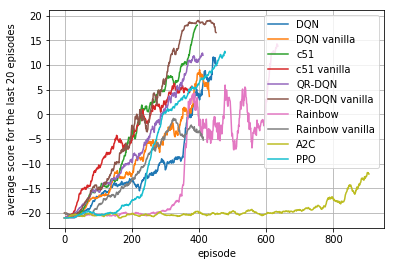

In [87]:
for alg in logs.keys():
    plt.plot(sliding_average(logs[alg]["rewards"], 20), label=alg)
plt.legend()
plt.xlabel("episode")
plt.ylabel("average score for the last 20 episodes")
plt.grid();

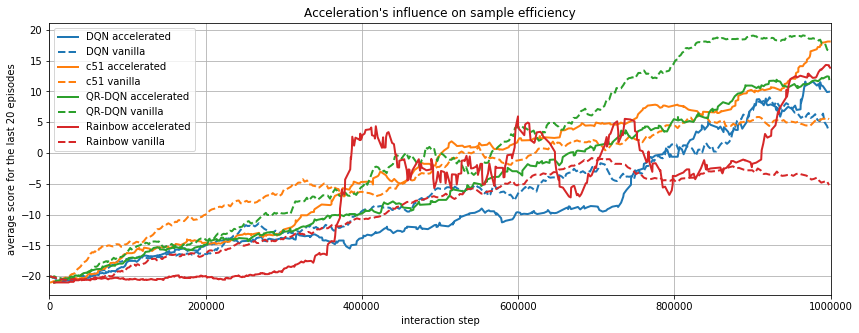

In [107]:
f = plt.figure(figsize=(14, 5))

for alg in ["DQN", "c51", "QR-DQN", "Rainbow"]:
    p = plt.plot(logs[alg]["episode ends"], sliding_average(logs[alg]["rewards"], 20), lw=2, label=alg + " accelerated")
    
    plt.plot(logs[alg + " vanilla"]["episode ends"], sliding_average(logs[alg + " vanilla"]["rewards"], 20), 
             color=p[0].get_color(), ls="--", lw=2, label=alg + " vanilla")

plt.legend()
plt.xlabel("interaction step")
plt.ylabel("average score for the last 20 episodes")
plt.grid();
plt.xlim(0, 1000000)
plt.title("Acceleration's influence on sample efficiency")

f.savefig("AcceleratingResults.pdf", bbox_inches='tight')

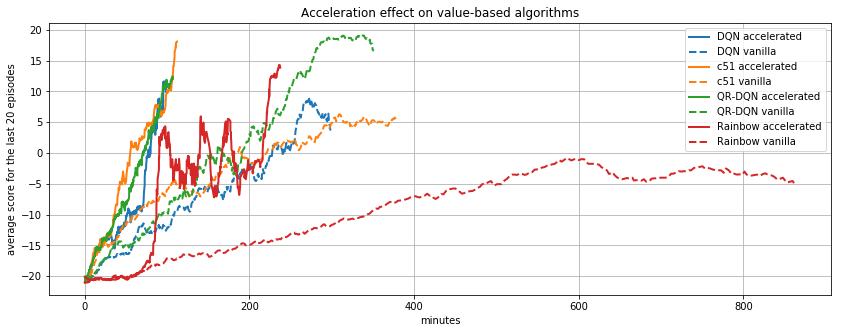

In [109]:
f = plt.figure(figsize=(14, 5))

for alg in ["DQN", "c51", "QR-DQN", "Rainbow"]:
    spf = 1000 / np.array(logs[alg]["fps"])
    time = np.cumsum(spf) / 60
    R = sliding_average(logs[alg]["rewards"], 20)
    p = plt.plot(time[np.array(logs[alg]["episode ends"]) // 1000], R, label=alg + " accelerated", lw=2)
    
    alg += " vanilla"
    
    spf = 1000 / np.array(logs[alg]["fps"])
    time = np.cumsum(spf) / 60
    R = sliding_average(logs[alg]["rewards"], 20)
    plt.plot(time[np.array(logs[alg]["episode ends"]) // 1000], R, label=alg, lw=2, ls='--', color=p[0].get_color())
    
plt.legend(loc=1)
plt.xlabel("minutes")
plt.ylabel("average score for the last 20 episodes")
plt.grid()
plt.title("Acceleration effect on value-based algorithms")

f.savefig("AcceleratingClockResults.pdf", bbox_inches='tight')

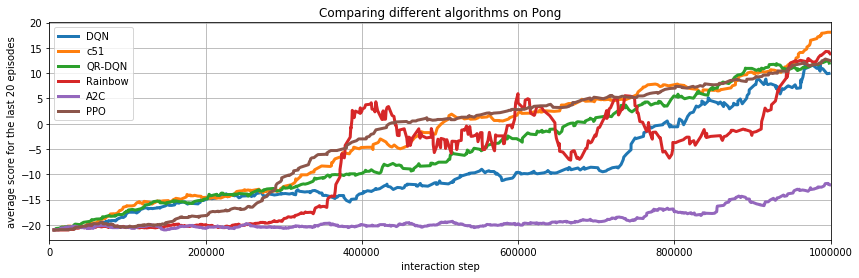

In [108]:
f = plt.figure(figsize=(14, 4))

for alg in logs.keys():
    if not " " in alg:
        plt.plot(logs[alg]["episode ends"], sliding_average(logs[alg]["rewards"], 20), lw=3, label=alg)
plt.legend()
plt.xlabel("interaction step")
plt.ylabel("average score for the last 20 episodes")
plt.grid();
plt.xlim(0, 1000000)
plt.title("Comparing different algorithms on Pong")

f.savefig("Results.pdf", bbox_inches='tight')

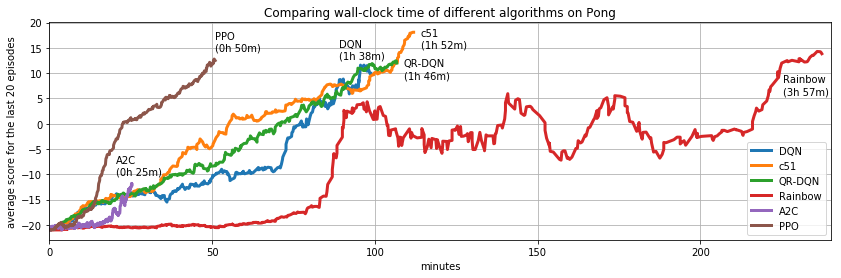

In [131]:
f = plt.figure(figsize=(14, 4))

for alg, shiftx, shifty in zip(['DQN', 'c51', 'QR-DQN', 'Rainbow', 'A2C', 'PPO'], 
                               [10, -2, -2, 12, 5, 0], [-3, 3, 3, 8, -2, -2]):
    spf = 1000 / np.array(logs[alg]["fps"])
    time = np.cumsum(spf) / 60
    R = sliding_average(logs[alg]["rewards"], 20)
    plt.plot(time[np.array(logs[alg]["episode ends"]) // 1000], R, label=alg, lw=3)
    
    plt.annotate(alg + "\n(" + str(int(time[-1]) // 60) + "h " + str(int(time[-1]) % 60) + "m" ")", 
                 xy=(time[-1] - shiftx, R[-1] - shifty))
    
plt.legend()
plt.xlabel("minutes")
plt.ylabel("average score for the last 20 episodes")
plt.xlim(0, 240)
plt.grid()
plt.title("Comparing wall-clock time of different algorithms on Pong")

f.savefig("ClockResults.pdf", bbox_inches='tight')